In [1]:
%matplotlib inline
import hashlib
import string
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size


A = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRZTUVWXYZ '
M = len(A)
Z = 50
N = 500

Key functions

In [2]:
def gen_seed(x_k, x_l):
    str_repr = ''.join(x_k.astype(str)) + ''.join(x_l.astype(str))
    return int(hashlib.sha256(str_repr.encode('utf-8')).hexdigest(), 16)  % 10**9
    

def braid(x_k, x_l, q):
    np.random.seed(gen_seed(x_k, x_l))
    mask = np.random.rand(len(x_k)) < 1/(q+1)
    u = x_k.copy()
    u[mask] = x_l[mask]
    return u


def hamming(x_k, x_l):
    return np.mean(x_k != x_l)

Setup

In [3]:
np.random.seed(0)
x_star = np.random.randint(0, Z, N)
xs = [np.random.randint(0, Z, N) for i in range(M)]

def encode(s):
    y = x_star.copy()
    for t, a in enumerate(s):
        idx = A.index(a)
        y = braid(y, xs[idx], t+1)
    return y


def decode(y, l, return_d=False, force_decode=None):
    # get *set* of elements in sequence
    min_idxs = np.argsort([hamming(x, y) for x in xs])[:l]
    vs = [xs[idx] for idx in min_idxs]
    # reconstruct sequence
    y_star = x_star.copy()
    s_hat = ''
    d = [hamming(y_star, y)]
    for t in range(1, l+1):
        us = [braid(y_star, v, t) for v in vs]
        j = np.argmin([hamming(u, y) for u in us])
        
        if force_decode is not None and len(force_decode) >= t:
            next_sym = force_decode[t-1]
            next_x = xs[A.index(next_sym)]
        else:
            next_sym = A[min_idxs[j]]
            next_x = vs[j]
            
        s_hat += next_sym
        y_star = braid(y_star, next_x, t)
        d.append(hamming(y_star, y))
        
    if not all(y_star == y):
        print('Default reconstruction failed.')
        
    if not return_d:
        return s_hat
    else:
        return s_hat, np.array(d)

Demo

In [4]:
print('Hamming similarities between symbols:')
symbol_dists = []
for k in range(M-1):
    for l in range(k+1, M):
        symbol_dists.append(1 - hamming(xs[k], xs[l]))
print('Min = ', np.min(symbol_dists))
print('Max = ', np.max(symbol_dists))
print('Mean = ', np.mean(symbol_dists))
print('Std = ', np.std(symbol_dists))

Hamming similarities between symbols:
Min =  0.0020000000000000018
Max =  0.04400000000000004
Mean =  0.02023076923076925
Std =  0.006152548847290739


In [5]:
s = 'random vectors for the win'
y = encode(s)
print(y)
s_star = decode(y, len(s))
print(s_star)

[25  9  0  3 27 25 47 34 41  9 12 11 31  1 25 41  1 12 42  1 21 16 30 18
  3 48 20 42 16  4 25 33  6  6 43 25 16 16  8 36 32 43 23 14 21 10 16 15
 13 48  4  9 23 26 44 24  1 33 28 33 37 27 18 44 48 47  0 43  2  4 49 34
 46 24 23  5 17 47 26  5 47  3 42 21 16 42  1 25 16 30  3  4 34 19 46 42
 15 31 23 16 24 30 39  2 31 40 28 18  5  1 39 29 13 30 21 29 30  6 29 45
 20 30 33 12  6 39 23 17 40 43 24 12  9  9 44 37 34  3 29 46 24 43 47  7
 37 12  9 30 21 38 37 41 22  1 24 21 13  2 33  4 17 45 25 10 43 19 20 10
  7 49 24 25  5 15  3 19 42  0 31 20 18  4 13 47  6 34 16 13 35 22  2 49
 37 18 49 41 24 30  0  5 42 38 47 18 47 24 11 28 29 20 10 31  6 48 24  5
 25 24 25  5 27 17 21 21 49  0 41 45 48 20  0 40 17 46  9 35 49 22 34 10
 18 20 38 11 18 32 20 18 38 15 46 22  9 26 26 47 22 20 41 21 26 45  8 26
 24 37 43 23 23 14 38  0 40 44 42 49 11 49 15 36  0  3 30 11 23 37 12  4
 25 34 32 23 41  8 20 16  8 17 10 20 18 28  9 31 27 44  0 26 46 24 36 45
 41 47 38 16  5 41 42 40 38 38  6 27 46 37 38 13 32

In [6]:
test_seqs = [
    'abcde',
    'abced',
    'aabcd',
    'zyxwv',
    'zyxvw',
    'aaazz',
    'abbbaaab',
    'hi agostina'
]

for s in test_seqs:
    s_hat = decode(encode(s), len(s))
    print(s, '--> y --> ', s_hat, '(', s == s_hat, ')')

abcde --> y -->  abcde ( True )
abced --> y -->  abced ( True )
aabcd --> y -->  aabcd ( True )
zyxwv --> y -->  zyxwv ( True )
zyxvw --> y -->  zyxvw ( True )
aaazz --> y -->  aaazz ( True )
abbbaaab --> y -->  abbbaaab ( True )
hi agostina --> y -->  hi agostina ( True )


Default reconstruction failed.


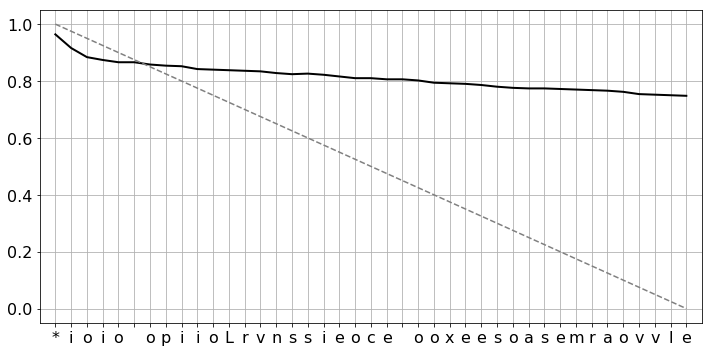

In [7]:
s = 'hyperdimensional computing via crossover'
y = encode(s)
s_hat, d = decode(y, len(s), return_d=True)

t = np.arange(len(s)+1)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
ax.plot(t, d, lw=2, c='k')

ax.plot(t, 1 - t/(len(t)-1), c='gray', ls='--')

ax.set_xlim(-1, len(t))
ax.set_ylim(-.05, 1.05)

ax.set_xticks(t)
ax.set_xticklabels('*' + s_hat)

ax.grid()

set_font_size(ax, 16)

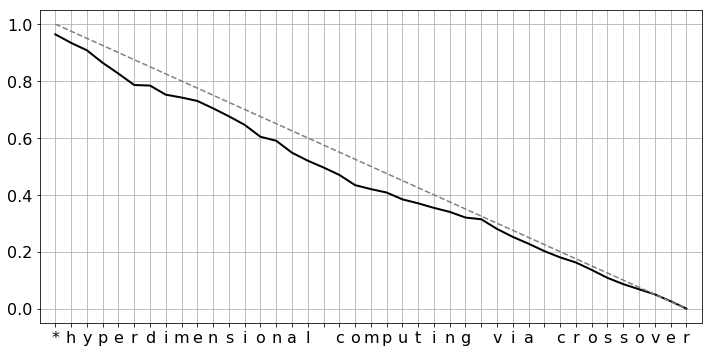

In [8]:
s = 'hyperdimensional computing via crossover'
y = encode(s)
s_hat, d = decode(y, len(s), return_d=True, force_decode='h')

t = np.arange(len(s)+1)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
ax.plot(t, d, lw=2, c='k')

ax.plot(t, 1 - t/(len(t)-1), c='gray', ls='--')

ax.set_xlim(-1, len(t))
ax.set_ylim(-.05, 1.05)

ax.set_xticks(t)
ax.set_xticklabels('*' + s_hat)

ax.grid()

set_font_size(ax, 16)

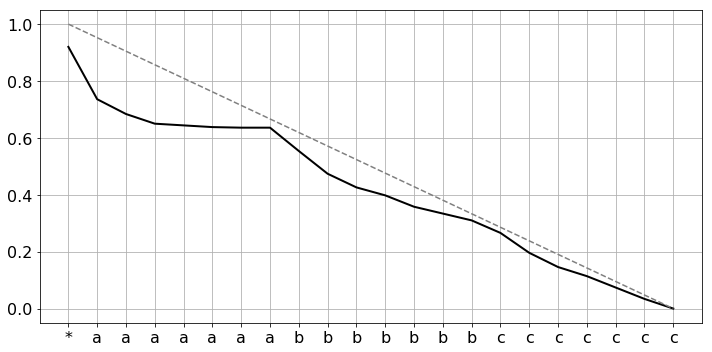

In [9]:
s = 'aaaaaaabbbbbbbccccccc'
y = encode(s)
s_hat, d = decode(y, len(s), return_d=True, force_decode='aaaaaaabbbbbbbccccccc')

t = np.arange(len(s)+1)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
ax.plot(t, d, lw=2, c='k')

ax.plot(t, 1 - t/(len(t)-1), c='gray', ls='--')

ax.set_xlim(-1, len(t))
ax.set_ylim(-.05, 1.05)

ax.set_xticks(t)
ax.set_xticklabels('*' + s_hat)

ax.grid()

set_font_size(ax, 16)